In [241]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # for kpss

In [242]:
start = "2018-01-01"
end = "2024-04-21"
start_test ="2024-04-22"
end_test = "2024-10-11"
df_vix = yf.download("^VIX",start,end)
df_gspc = yf.download("^GSPC",start,end)
df_vix_test = yf.download("^VIX",start_test,end_test)

df_vix.columns = df_vix.columns.str.lower()
df_vix_test.columns = df_vix_test.columns.str.lower()
df_gspc.columns = df_gspc.columns.str.lower()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [243]:
df_vix_test = df_vix_test[['close']]

In [244]:
# EDA CHECK
pd.DataFrame.equals(df_vix['close'], df_vix['adj close'])
df_vix = df_vix[['close']]
df_vix.head(10)

,close
Date,
2018-01-02,9.77
2018-01-03,9.15
2018-01-04,9.22
2018-01-05,9.22
2018-01-08,9.52
2018-01-09,10.08
2018-01-10,9.82
2018-01-11,9.88
2018-01-12,10.16


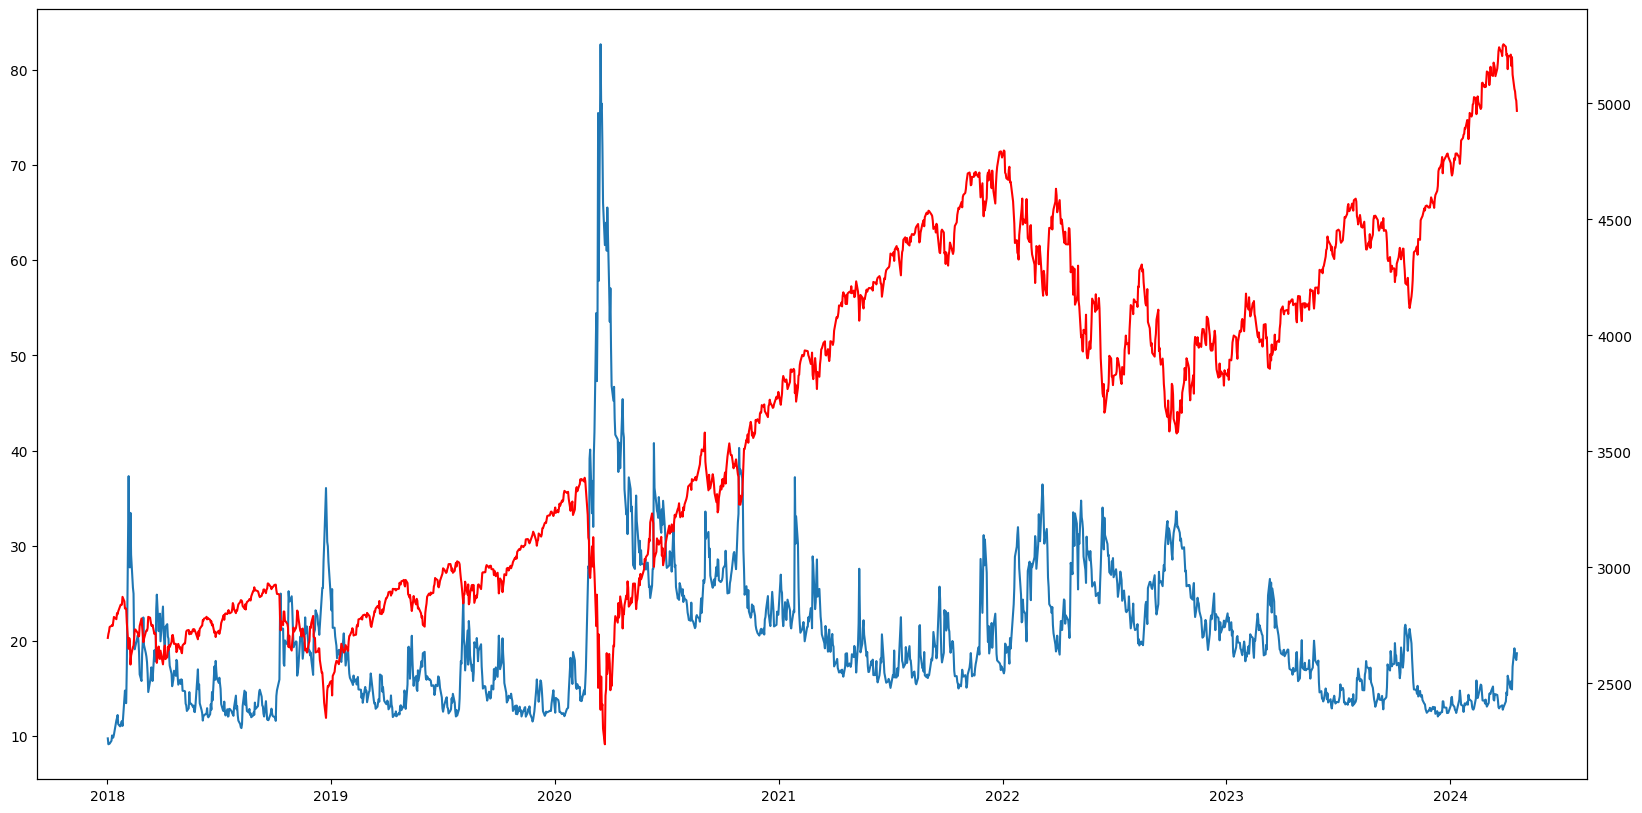

In [245]:
plt.figure(figsize=(20,10))
plt.plot(df_vix['close'], label ='vix')
plt.gca().twinx().plot(df_gspc['close'], color = 'red', label ='sp500')

# 1. CHECK STATIONARY
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [246]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [247]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [248]:
# NULL = STATIONARY
# ALTERNATE = NON STATIONARY
# cant reject NULL at 95% confidence interval; the series is stationary
kpsstest = kpss_test(df_vix)

Results of KPSS Test:
Test Statistic            0.461469
p-value                   0.050660
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [249]:
# NULL = non stationary
# ALTERNATE = STATIONARY
# can reject NULL at 95% and 99% confidence interval; The series has no unit root. (series is stationary)
adftest = adf_test(df_vix)

Results of Dickey-Fuller Test:
Test Statistic                   -4.544592
p-value                           0.000163
#Lags Used                        9.000000
Number of Observations Used    1575.000000
Critical Value (1%)              -3.434509
Critical Value (5%)              -2.863377
Critical Value (10%)             -2.567748
dtype: float64


It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

seems to be case 2 without doing anything !


# ACF TEST

In [250]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

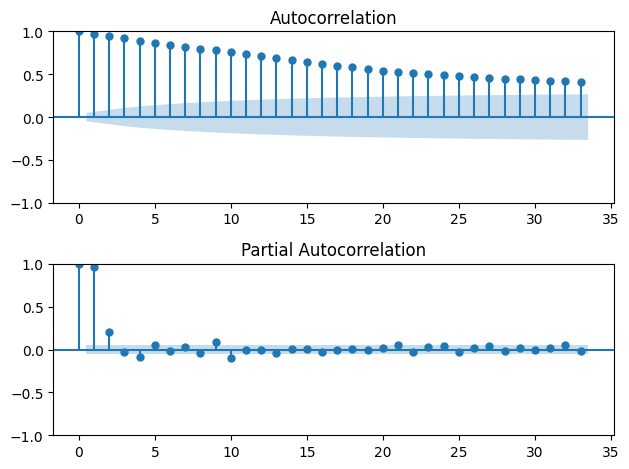

In [251]:

f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_vix['close'], ax=ax[0])
plot_pacf(df_vix['close'], ax=ax[1], method='ols')
plt.tight_layout()
plt.show()


# judging visually seems to suggest this is atleast AR1


In [252]:
# from statsmodels.tsa.ar_model import AutoReg
# params = AutoReg(df_vix['close'], lags = [1])
# res = params.fit()
# res.summary()

In [253]:
# Visually this is AR1, but we let the ar_select_order decide
from statsmodels.tsa.ar_model import ar_select_order
select = ar_select_order(df_vix['close'], 15, "aic", trend="c", seasonal=False)
print(select.ar_lags) # show all selected lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/home/kilo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kilo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [254]:
res = select.model.fit()
print("AIC: {0} \nBIC: {1} \nHQIC: {2}".format(res.aic, res.bic, res.hqic))

AIC: 6691.604184379366 
BIC: 6755.948310994483 
HQIC: 6715.51617801524


In [255]:
testing = pd.concat([df_vix['close'],df_vix_test['close']])
prediction = []

for i in range(len(df_vix['close']), len(df_vix['close']) + len(df_vix_test['close'])):
    updated_res = res.apply(testing[:i])
    prediction.append(updated_res.forecast(1).iloc[0])


/home/kilo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kilo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/kilo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/kilo/.local/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The inde

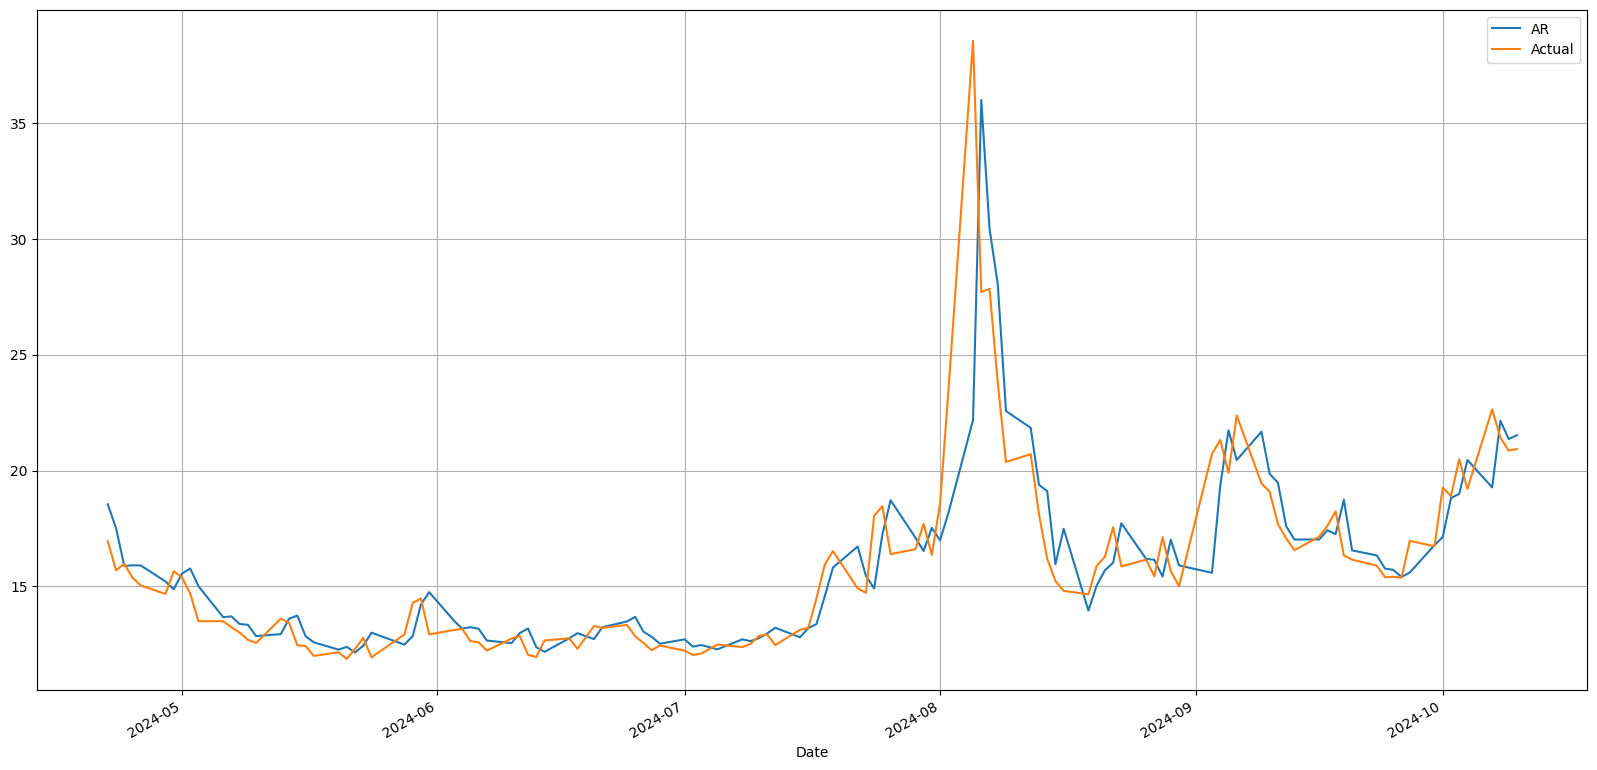

In [258]:
predictions = pd.DataFrame({
    "AR": prediction,
    "Actual": df_vix_test['close'],
})
_, ax = plt.subplots(figsize =(20,10))
ax = predictions.plot(ax=ax)
ax.grid()